# Import

In [1]:
!pwd
!python --version
!which python

/home/shpaik/22-ijcai2022/Fig4/run_real_lastfm
Python 3.6.10 :: Anaconda, Inc.
/home/shpaik/anaconda3/envs/py36/bin/python


In [2]:
import os
current_dir = os.getcwd()
print(current_dir)

# control the maximum number of threads that numpy uses by 8
os.environ["OMP_NUM_THREADS"] = "36" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "36" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "36" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "36" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "36" # export NUMEXPR_NUM_THREADS=6

/home/shpaik/22-ijcai2022/Fig4/run_real_lastfm


In [32]:
my_data = "lastfm"

data_number = 5
data_number = str(data_number)

we_need_tuning =True # True : tuning will be inclued / False : use already tuned paramter

# previous experimental results
TUNED_V_LAM = {
     'Random': {'v': 0.01, 'lam': 0.008},
     'RGraphTS': {'v': 0.001, 'lam': 5.0},
     'LinTS': {'v': 0.001, 'lam': 0.2},
     'SCLUB': {'v': 10.0, 'lam': 0.04},
     'CLUB': {'v': 0.01, 'lam': 0.2},
     'DyClu': {'v': 10.0, 'lam': 0.04},
     'SemiRGraphTS': {'v': 0.001, 'lam': 5.0},
     'GraphUCBlocal': {'v': 10.0, 'lam': 0.04},
     'SemiTS': {'v': 0.001, 'lam': 5.0},
     'LinTS_Single': {'v': 0.1, 'lam': 0.2},
     'SemiTS_Single': {'v': 1.0, 'lam': 1.0}
}

In [4]:
os.chdir("../../")
from lib_external import SCLUB
from lib_external import DyClu
os.chdir(current_dir)

In [5]:
%run REAL_functions.ipynb

In [6]:
import numpy as np 
import networkx as nx
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import Normalizer, MinMaxScaler
from scipy.sparse import csgraph 
import scipy
import os
import random
from sklearn import datasets
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
import time
from datetime import datetime
import sys
mod = sys.modules[__name__]

In [7]:
plt.style.use("ggplot")

[]

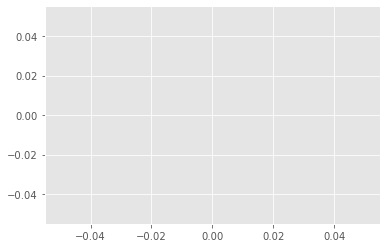

In [8]:
plt.figure()
plt.plot()

In [9]:
real_data_dir = current_dir + "/" + "preproc_output"
# full user information
user_IDs_full = np.load(real_data_dir +"/user_IDs_full.npy")  
adjmtx_full = np.load(real_data_dir +"/adjmtx_full.npy")  
item_IDs_full = np.load(real_data_dir +"/item_IDs_full.npy")  
item_features_full = np.load(real_data_dir +"/item_features_full.npy")   
# generated history    # allow_pickle=True is required for loading np array of objects
list_items = np.load(real_data_dir +"/list_items_"+ data_number + ".npy", allow_pickle=True)  
list_items_rwd1 = np.load(real_data_dir +"/list_items_rwd1_"+ data_number + ".npy", allow_pickle=True)
list_item_features = np.load(real_data_dir +"/list_item_features_"+ data_number + ".npy", allow_pickle=True)
list_user_history = np.load(real_data_dir +"/list_user_history_"+ data_number + ".npy", allow_pickle=True)

In [10]:
# some exploration
print(user_IDs_full)
print(user_IDs_full.shape)
print(adjmtx_full.shape)
print(item_IDs_full)
print(item_IDs_full.shape)
print(item_features_full.shape)
print(len(list_items))
print(len(list_items_rwd1))
print(len(list_item_features))
print(len(list_user_history))

print(list_items.shape)
print(list_items[0].shape)
print(list_items_rwd1.shape)
print(list_items_rwd1[0].shape)
print(list_items_rwd1[3].shape)
print(list_item_features.shape)
print(list_item_features[0].shape)
print(list_user_history.shape)
print(list_user_history[0])

[   2    3    4 ... 2097 2099 2100]
(1892,)
(1892, 1892)
[    1     2     3 ... 18740 18741 18744]
(12523,)
(12523, 25)
150000
150000
150000
150000
(150000,)
(25,)
(150000,)
(2,)
(3,)
(150000,)
(25, 25)
(150000,)
2057


In [11]:
simul_n = 5

user_num = user_IDs_full.shape[0]
arm_num = list_item_features[0].shape[0]
dimension = list_item_features[0].shape[1]
gamma = 10

time_horizon = 50000
tuning_time_horizon = 5000

IMG_FOLDER = "results"+"/" + my_data +"_" +data_number
IMG_FOLDER_FOR_OS = current_dir+"/"+IMG_FOLDER

## Other settings

In [12]:
tuning_simul_n = 1

print("--------------------")
const_R = 0.1
delta = 0.05
epsilon = 1

################################## v_set and lam_set ##################################
v_set=[0.001, 0.01, 0.1, 1., 10.]
lam_set=[0.008, 0.04, 0.2, 1., 5.]

v_num = len(v_set); lam_num = len(lam_set)
v_and_lam_num = v_num * lam_num

##### For DyClu (default option) ####
dyclu_options = {
    'tau_e': 20, # size of sliding window,
    'alpha': 0.3,
    'delta_1': 1e-1,
    'delta_2': 1e-1,
    'change_detection_alpha': 0.01,
    'neighbor_identification_alpha': 0.01 ,
    'dataSharing': False, 
    'aggregationMethod': 'combine',
    'useOutdated': True ,
    'maxNumOutdatedModels': None, 
}

##### unnecessary #####
threshold = 0.5
prob = 0.4
lap_type = "random_walk"
our_graph_type = "ER" 
nu_type = "0"
arm_type = "sparse"

##### obsolete #####
const_alpha_2 = 0.15 
const_tol_1 = dimension 
const_tol_2 = const_tol_1 * 1e-5 
print(f"to1_1: {const_tol_1}, to1_2: {const_tol_2},")

--------------------
to1_1: 25, to1_2: 0.00025,


## Graph & Laplacian

In [13]:
our_graph = adjmtx_full
our_laplacian = graph_to_laplacian(our_graph, 'random_walk')
symm_laplacian = graph_to_laplacian(our_graph, 'symmetric_normalized')

In [14]:
print(our_graph)
print(our_laplacian)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


## Tuning

In [15]:
tuning_models=["Random", "LinTS", "SemiRGraphTS", "GraphUCBlocal","SemiTS","LinTS_Single", \
                  "SemiTS_Single"]
running_models=["Random", "LinTS", "SemiRGraphTS", "GraphUCBlocal","SemiTS","LinTS_Single", \
                  "SemiTS_Single", "SCLUB", "DyClu"]

In [16]:
if we_need_tuning == True:
    Labels, results = \
        tuning_v_and_lam_for_all_algo_real(tuning_models, \
             list_user_history, user_IDs_full, list_item_features, list_items, list_items_rwd1, \
             v_set, lam_set, user_num, arm_num, dimension, tuning_time_horizon, const_R, delta, \
             tuning_simul_n, epsilon, threshold, prob, gamma, our_graph, our_laplacian, \
             symm_laplacian, const_alpha_2, const_tol_1, const_tol_2, nu_type, arm_type,add_intercept=True)
else:
    print("No tuning.")

<set models>
LinTS, time = 0.027013540267944336 sec
SemiRGraphTS, time = 0.0507197380065918 sec
GraphUCBlocal, time = 0.06427526473999023 sec
SemiTS, time = 0.0441591739654541 sec
LinTS_Single, time = 0.00013399124145507812 sec
SemiTS_Single, time = 8.702278137207031e-05 sec
0 user: 1854 / opt_arm: exist / time : 0.087 sec
=====
250 user: 512 / opt_arm: exist / time : 0.066 sec
=====
500 user: 321 / opt_arm: exist / time : 0.066 sec
=====
750 user: 1835 / opt_arm: exist / time : 0.067 sec
=====
1000 user: 785 / opt_arm: exist / time : 0.067 sec
=====
1250 user: 78 / opt_arm: exist / time : 0.068 sec
=====
1500 user: 961 / opt_arm: exist / time : 0.067 sec
=====
1750 user: 1036 / opt_arm: exist / time : 0.068 sec
=====
2000 user: 997 / opt_arm: exist / time : 0.072 sec
=====
2250 user: 676 / opt_arm: exist / time : 0.069 sec
=====
2500 user: 345 / opt_arm: exist / time : 0.069 sec
=====
2750 user: 1357 / opt_arm: exist / time : 0.069 sec
=====
3000 user: 802 / opt_arm: exist / time : 0.

/home/shpaik/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: covariance is not positive-semidefinite.
/home/shpaik/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: covariance is not positive-semidefinite.


1500 user: 961 / opt_arm: exist / time : 0.088 sec
=====
1750 user: 1036 / opt_arm: exist / time : 0.087 sec
=====
2000 user: 997 / opt_arm: exist / time : 0.088 sec
=====
2250 user: 676 / opt_arm: exist / time : 0.072 sec
=====
2500 user: 345 / opt_arm: exist / time : 0.072 sec
=====
2750 user: 1357 / opt_arm: exist / time : 0.072 sec
=====
3000 user: 802 / opt_arm: exist / time : 0.072 sec
=====
3250 user: 1640 / opt_arm: exist / time : 0.072 sec
=====
3500 user: 1344 / opt_arm: exist / time : 0.073 sec
=====
3750 user: 1182 / opt_arm: exist / time : 0.072 sec
=====
4000 user: 492 / opt_arm: exist / time : 0.089 sec
=====
4250 user: 1813 / opt_arm: exist / time : 0.072 sec
=====
4500 user: 878 / opt_arm: exist / time : 0.072 sec
=====
4750 user: 22 / opt_arm: exist / time : 0.072 sec
=====
iteration = 1/1, time = 404.338 sec
Random: 0.1088 ms
LinTS: 0.3424 ms
SemiRGraphTS: 22.6376 ms
GraphUCBlocal: 42.7551 ms
SemiTS: 7.4507 ms
LinTS_Single: 0.447 ms
SemiTS_Single: 7.004 ms
TOTAL TIME

/home/shpaik/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: covariance is not positive-semidefinite.
/home/shpaik/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:58: RuntimeWarning: covariance is not positive-semidefinite.


250 user: 512 / opt_arm: exist / time : 0.072 sec
=====
500 user: 321 / opt_arm: exist / time : 0.072 sec
=====
750 user: 1835 / opt_arm: exist / time : 0.073 sec
=====
1000 user: 785 / opt_arm: exist / time : 0.073 sec
=====
1250 user: 78 / opt_arm: exist / time : 0.106 sec
=====
1500 user: 961 / opt_arm: exist / time : 0.072 sec
=====
1750 user: 1036 / opt_arm: exist / time : 0.072 sec
=====
2000 user: 997 / opt_arm: exist / time : 0.072 sec
=====
2250 user: 676 / opt_arm: exist / time : 0.072 sec
=====
2500 user: 345 / opt_arm: exist / time : 0.073 sec
=====
2750 user: 1357 / opt_arm: exist / time : 0.072 sec
=====
3000 user: 802 / opt_arm: exist / time : 0.073 sec
=====
3250 user: 1640 / opt_arm: exist / time : 0.072 sec
=====
3500 user: 1344 / opt_arm: exist / time : 0.073 sec
=====
3750 user: 1182 / opt_arm: exist / time : 0.072 sec
=====
4000 user: 492 / opt_arm: exist / time : 0.072 sec
=====
4250 user: 1813 / opt_arm: exist / time : 0.072 sec
=====
4500 user: 878 / opt_arm: ex

## Choose best hyper parameters

Random


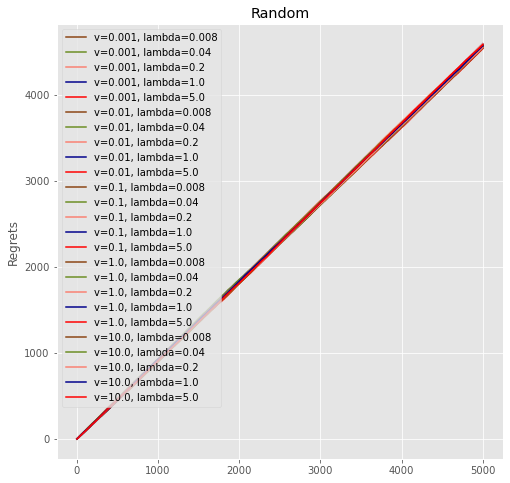

LinTS


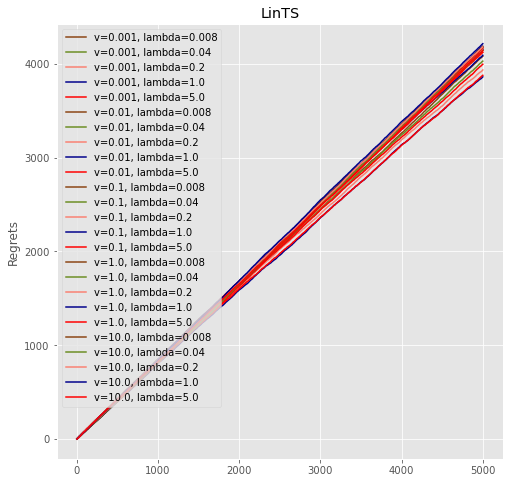

SemiRGraphTS


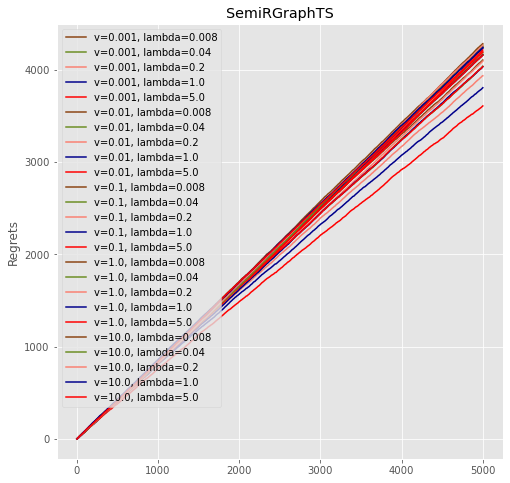

GraphUCBlocal


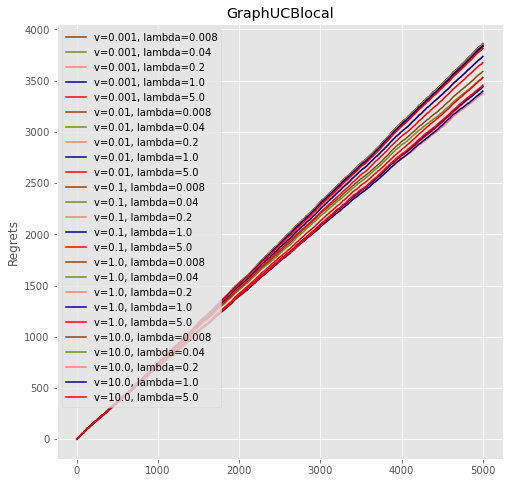

SemiTS


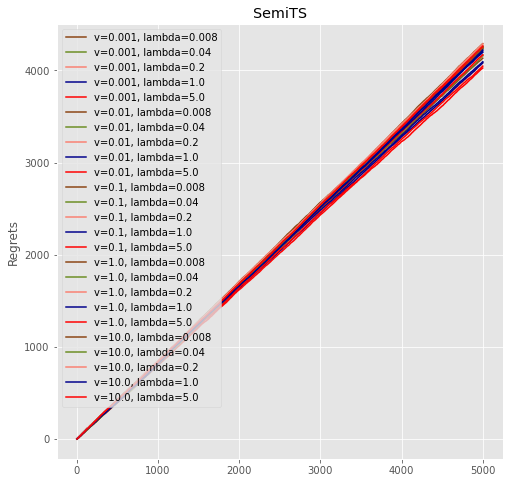

LinTS_Single


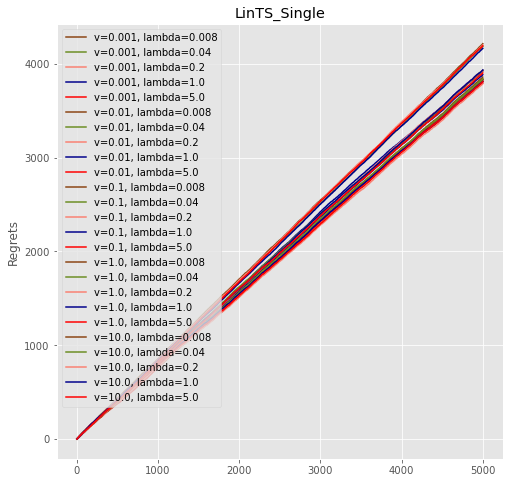

SemiTS_Single


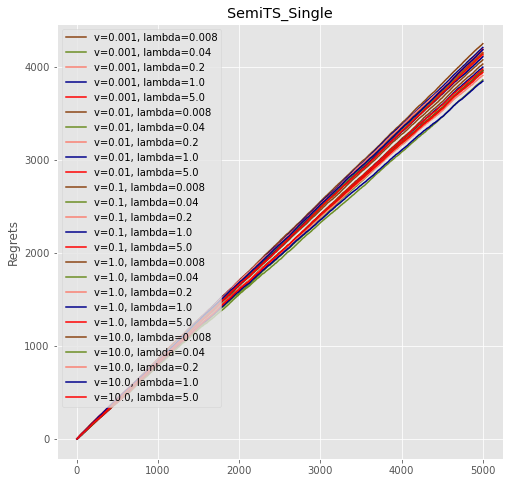

In [17]:
if we_need_tuning == True:
    algo_list = tuning_models
    colors=["black", "darkred", "peru", "darkorange", "gold",
            "yellowgreen", "limegreen", "lightseagreen", "deepskyblue", "blue",
            "darkviolet", "magenta", "khaki", "plum", "grey",
            "steelblue", "lightcoral", "bisque", "darkolivegreen", "darkcyan",
            "saddlebrown", "olivedrab", "salmon", "darkblue", "red",
            "black", "darkred", "peru", "darkorange", "gold"]

    colors_by_lam = []
    temp = colors[20:20+lam_num]
    for i in range(v_num):
        colors_by_lam += temp

    colors_by_v = []
    for i in range(lam_num):
        temp = [colors[20+i] for j in range(v_num)]
        colors_by_v += temp

    RT_dict = {}
    for MODEL in algo_list:
        print(MODEL)
        #RT_dict[MODEL] = show_tuning_results(MODEL, v_and_lam_num, colors, Labels, results)
        RT_dict[MODEL] = show_tuning_results(MODEL, v_and_lam_num, colors_by_lam, Labels, results)
        #RT_dict[MODEL] = show_tuning_results(MODEL, v_and_lam_num, colors_by_v, Labels, results)
else:
    print("No tuning.")

## Checkpoint: best tuning result of each algorithm

#n=1892,arms=25,d=25,T=5000,arm_type=sparse
Random: v= 0.01, lam = 5.0
RGraphTS: v= 1.1, lam = 1.1
LinTS: v= 0.001, lam = 1.0
SCLUB: v= 1.1, lam = 1.1
CLUB: v= 1.1, lam = 1.1
DyClu: v= 1.1, lam = 1.1
SemiRGraphTS: v= 0.001, lam = 5.0
GraphUCBlocal: v= 0.001, lam = 0.2
SemiTS: v= 0.001, lam = 5.0
LinTS_Single: v= 0.1, lam = 0.2
SemiTS_Single: v= 1.0, lam = 1.0



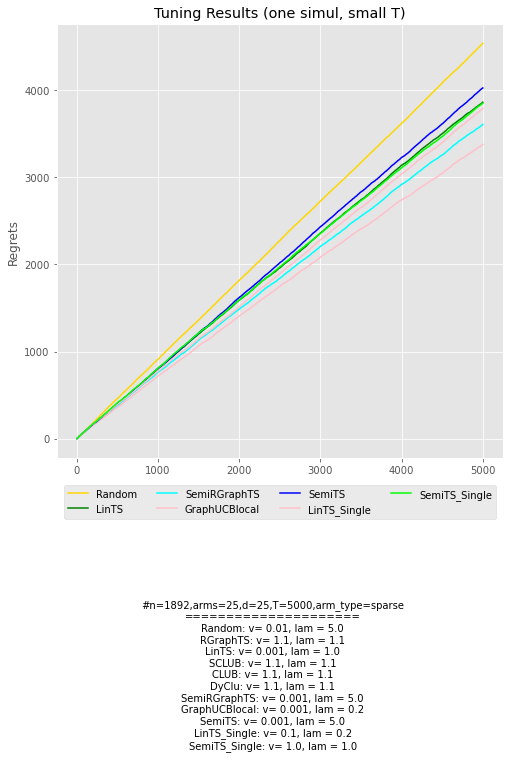

In [33]:
colors = ["gold", "r","g","brown","k","slategrey","aqua","pink", "blue", "pink", "lime", "m"]
if we_need_tuning == True:
    best_v_lam_pair_dict, _ = return_best_v_and_lambda_pair_real(tuning_models, user_num, arm_num, dimension, tuning_time_horizon, arm_type, colors, results, RT_dict)
    TUNED_V_LAM.update(best_v_lam_pair_dict)
    best_v_lam_pair_dict = TUNED_V_LAM
else:
    print("No tuning.")
    best_v_lam_pair_dict = TUNED_V_LAM
    
tuning_info = str(best_v_lam_pair_dict).replace('}, ', '}\n')[1:-1]

In [34]:
print("we_need_tuning =", we_need_tuning)
print(best_v_lam_pair_dict)

we_need_tuning = True
{'Random': {'v': 0.01, 'lam': 5.0}, 'RGraphTS': {'v': 1.1, 'lam': 1.1}, 'LinTS': {'v': 0.001, 'lam': 1.0}, 'SCLUB': {'v': 1.1, 'lam': 1.1}, 'CLUB': {'v': 1.1, 'lam': 1.1}, 'DyClu': {'v': 1.1, 'lam': 1.1}, 'SemiRGraphTS': {'v': 0.001, 'lam': 5.0}, 'GraphUCBlocal': {'v': 0.001, 'lam': 0.2}, 'SemiTS': {'v': 0.001, 'lam': 5.0}, 'LinTS_Single': {'v': 0.1, 'lam': 0.2}, 'SemiTS_Single': {'v': 1.0, 'lam': 1.0}}


## Final simulation with best hyper parameters

In [ ]:
cumulated_regret_dict, info_computing_time = \
    run_all_algo_with_best_v_lam_real(running_models, list_user_history, \
          user_IDs_full, list_item_features, list_items, list_items_rwd1, \
          best_v_lam_pair_dict, user_num, arm_num,  dimension, time_horizon, const_R, \
          delta, simul_n, epsilon, threshold, prob, gamma, our_graph, our_laplacian, \
          symm_laplacian, const_alpha_2, const_tol_1, const_tol_2, nu_type, \
          arm_type, add_intercept=True)

<set models>
LinTS, time = 0.025113344192504883 sec
SemiRGraphTS, time = 0.045722246170043945 sec
GraphUCBlocal, time = 0.050942182540893555 sec
SemiTS, time = 0.03762960433959961 sec
LinTS_Single, time = 0.0001404285430908203 sec
SemiTS_Single, time = 6.985664367675781e-05 sec
SCLUB, time = 0.018281221389770508 sec
DyClu, time = 7.82012939453125e-05 sec
0 user: 1854 / opt_arm: exist / time : 0.066 sec
cum_rwds
=====
500 user: 321 / opt_arm: exist / time : 0.221 sec
cum_rwds
=====
1000 user: 785 / opt_arm: exist / time : 0.268 sec
cum_rwds
=====
1500 user: 961 / opt_arm: exist / time : 0.328 sec
cum_rwds
=====
2000 user: 997 / opt_arm: exist / time : 0.377 sec
cum_rwds
=====
2500 user: 345 / opt_arm: exist / time : 0.42 sec
cum_rwds
=====
3000 user: 802 / opt_arm: exist / time : 0.459 sec
cum_rwds
=====
3500 user: 1344 / opt_arm: exist / time : 0.473 sec
cum_rwds
=====
4000 user: 492 / opt_arm: exist / time : 0.494 sec
cum_rwds
=====
4500 user: 878 / opt_arm: exist / time : 0.511 sec
c

## Final plot

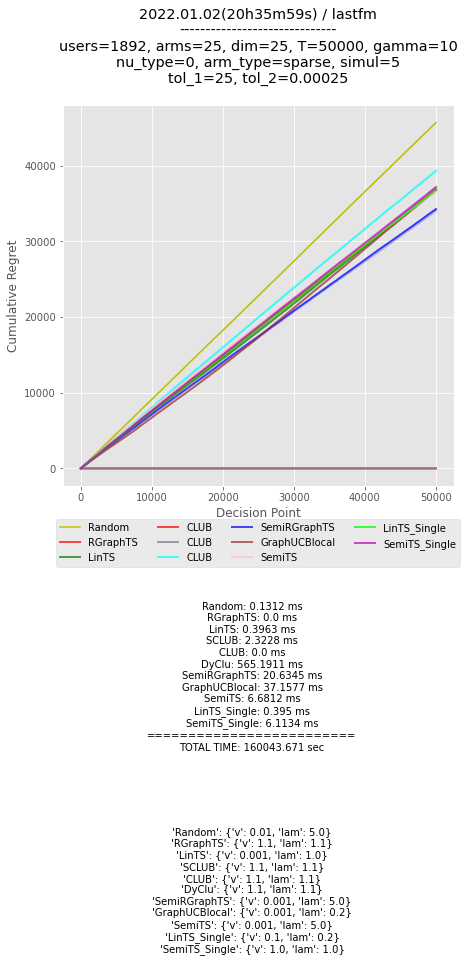


<parameters>
user_num = 1892 / arm_num = 25 / dimension = 25
delta = 0.05 / R = 0.1 / gamma (for smooth Theta) = 10
-----
const_tol_1 = 25 / const_tol_2 = 0.00025
graph = ER / laplacian=random_walk / threshold = 0.5 / prob = 0.4 / const_alpha_2 = 0.15
########################################

<mean computing time>
Random: 0.1312 ms
RGraphTS: 0.0 ms
LinTS: 0.3963 ms
SCLUB: 2.3228 ms
CLUB: 0.0 ms
DyClu: 565.1911 ms
SemiRGraphTS: 20.6345 ms
GraphUCBlocal: 37.1577 ms
SemiTS: 6.6812 ms
LinTS_Single: 0.395 ms
SemiTS_Single: 6.1134 ms
TOTAL TIME: 160043.671 sec
########################################

<best tuning parameter>
'Random': {'v': 0.01, 'lam': 5.0}
'RGraphTS': {'v': 1.1, 'lam': 1.1}
'LinTS': {'v': 0.001, 'lam': 1.0}
'SCLUB': {'v': 1.1, 'lam': 1.1}
'CLUB': {'v': 1.1, 'lam': 1.1}
'DyClu': {'v': 1.1, 'lam': 1.1}
'SemiRGraphTS': {'v': 0.001, 'lam': 5.0}
'GraphUCBlocal': {'v': 0.001, 'lam': 0.2}
'SemiTS': {'v': 0.001, 'lam': 5.0}
'LinTS_Single': {'v': 0.1, 'lam': 0.2}
'SemiTS_Single': 

In [41]:
NOW = datetime.now().strftime('%Y.%m.%d(%Hh%Mm%Ss)')
IMG_NAME = my_data +"_" + data_number + "_T" + str(time_horizon)+ "_simul"+str(simul_n) +"("+ NOW+ ").png"
IMG_PATH = IMG_FOLDER+ "/"+IMG_NAME

IMG_FOLDER_FOR_OS = current_dir+"/"+IMG_FOLDER

if not os.path.exists(IMG_FOLDER_FOR_OS):
    os.makedirs(IMG_FOLDER_FOR_OS)

SAVE = True # False

const_linewidth = 2
const_transparency = 0.7
const_cut_random = 1 # Random
const_cut_semi = 1 # SemiRGraphTS

show_and_save_plot(SAVE, const_linewidth, const_transparency, const_cut_random, const_cut_semi, cumulated_regret_dict, user_num, arm_num,  dimension, time_horizon, const_R, delta, simul_n, epsilon, threshold, prob, gamma, lap_type, our_graph_type, const_alpha_2, const_tol_1, const_tol_2, nu_type, arm_type, info_computing_time, tuning_info, IMG_PATH, NOW+" / "+ my_data)

In [42]:
print(NOW)

2022.01.02(20h35m59s)


##  Ratio: cumulated regret of ALGORITHM / cumulated regert of RANDOM

Random
LinTS
SemiRGraphTS
GraphUCBlocal
SemiTS
LinTS_Single
SemiTS_Single
SCLUB
DyClu


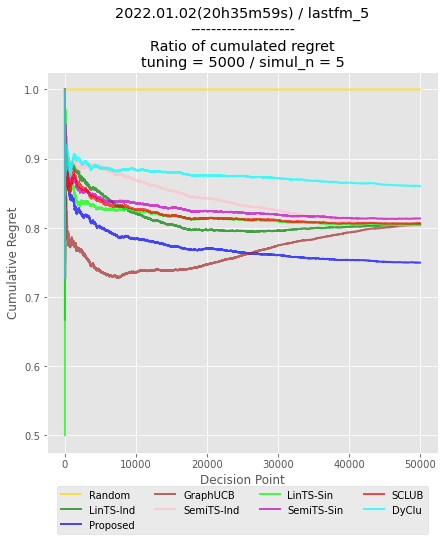

In [43]:
start = 0 # ignore round 1 to "start"
steps=np.arange(start+1,time_horizon+1)

LW = const_linewidth
TP = const_transparency
plt.figure(figsize=(7,7))

colors_dict = {"Random": "gold",
               "RGraphTS" : "r",
               "LinTS" : "g",
               "SemiRGraphTS" : "blue",
               "GraphUCBlocal" : "brown",
               "CLUB" : "slategrey",
               "SCLUB" : "r",
               "DyClu" : "aqua",
               "SemiTS" : "pink",
               "LinTS_Single" : "lime",
               "SemiTS_Single": "m"}

labels_dict = {"Random": "Random",
               "RGraphTS" : "Proposed-Stationary",
               "LinTS" : "LinTS-Ind",
               "SemiRGraphTS" : "Proposed",
               "GraphUCBlocal" : "GraphUCB",
               "CLUB" : "CLUB",
               "SCLUB" : "SCLUB",
               "DyClu" : "DyClu",
               "SemiTS" : "SemiTS-Ind",
               "LinTS_Single" : "LinTS-Sin",
               "SemiTS_Single": "SemiTS-Sin"}

denominator = np.median(cumulated_regret_dict["Random"], axis=0)[start:]

for MODEL in running_models:
    print(MODEL)
    COLOR = colors_dict[MODEL]
    numerator = np.median(cumulated_regret_dict[MODEL], axis=0)[start:]
    fraction = np.divide(numerator, denominator)
    plt.plot(steps, fraction, COLOR, linewidth = LW, alpha =  TP, label=labels_dict[MODEL])
    
plt.xlabel('Decision Point')
plt.ylabel('Cumulative Regret')
if we_need_tuning == True:
    plt.title(NOW+" / "+ my_data +"_" + data_number + "\n--------------------\n"+"Ratio of cumulated regret\n"+"tuning = " + str(tuning_time_horizon)+" / simul_n = " + str(simul_n))
else:
    plt.title(NOW+" / "+ my_data +"_" + data_number + "\n--------------------\n"+"Ratio of cumulated regret\n"+"tuning = " + "NO"+" / simul_n = " + str(simul_n))
plt.legend(loc='center', bbox_to_anchor=(0.5,-0.15),fancybox=True,ncol=4)

if SAVE == True:
    RATIO_FOLDER = IMG_FOLDER+"/ratio_image_folder"
    RATIO_FOLDER_FOR_OS = current_dir+"/"+ RATIO_FOLDER
    if not os.path.exists(RATIO_FOLDER_FOR_OS):
        os.makedirs(RATIO_FOLDER_FOR_OS)
        
    plt.savefig(RATIO_FOLDER+"/"+ my_data +"_" + data_number + "_ratio_"+ NOW+ ".png", bbox_inches='tight')
    
plt.show()

In [44]:
if SAVE == True:
    REGRET_FOLDER = IMG_FOLDER+"/regret_saving_folder/regret_"+NOW
    REGRET_FOLDER_FOR_OS = current_dir+"/"+REGRET_FOLDER
    if not os.path.exists(REGRET_FOLDER_FOR_OS):
        os.makedirs(REGRET_FOLDER_FOR_OS)

    for MODEL in running_models:
        np.save(REGRET_FOLDER+'/cumulated_regret_'+ MODEL +'.npy', cumulated_regret_dict[MODEL])

In [45]:
print(NOW)

2022.01.02(20h35m59s)
